In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import lightgbm as lgb
import shap
import lime
import os
from joblib import dump
from IPython.display import IFrame
import tempfile
import warnings
import joblib
import statsmodels.api as sm

warnings.filterwarnings('ignore')
# import dask.dataframe as dd


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
exps_dir = "../../exps"
if os.path.exists(exps_dir) == False: # tạo thư mục (nếu chưa có)
  os.makedirs(exps_dir, exist_ok=True)

save_dir = f"{exps_dir}/exp"
os.makedirs(save_dir, exist_ok=True)

In [3]:
ndays=1
X=pd.read_csv(f'{save_dir}/X_train_lag{ndays}_pre_processing.csv', index_col=None)
y=pd.read_csv(f'{save_dir}/y_train_lag{ndays}_pre_processing.csv', index_col=None)
X_train=pd.read_csv(f'{save_dir}/X_train_train_lag{ndays}_pre_processing.csv', index_col=None)
X_valid=pd.read_csv(f'{save_dir}/X_valid_train_lag{ndays}_pre_processing.csv', index_col=None)
y_train=pd.read_csv(f'{save_dir}/y_train_train_lag{ndays}_pre_processing.csv', index_col=None)
y_valid=pd.read_csv(f'{save_dir}/y_valid_train_lag{ndays}_pre_processing.csv', index_col=None)
best_params = dict(np.load(f'{save_dir}/best_params_.npz',allow_pickle=True))

KeyboardInterrupt: 

In [ ]:
X.drop(columns=['Unnamed: 0'], inplace=True)
y.drop(columns=['Unnamed: 0'], inplace=True)
X_train.drop(columns=['Unnamed: 0'], inplace=True)
X_valid.drop(columns=['Unnamed: 0'], inplace=True)
y_train.drop(columns=['Unnamed: 0'], inplace=True)
y_valid.drop(columns=['Unnamed: 0'], inplace=True)
print(X.shape, y.shape, X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)

(1622156, 102) (1622156, 1) (1086844, 102) (1086844, 1) (535312, 102) (535312, 1)


### Analyze the regression relation

#### Use OLS regression

In [ ]:
def analyze_OLS(x,y):
    x = sm.add_constant(x)  
    model = sm.OLS(y, x,hasconst=True)
    results = model.fit()
    summary = results.summary()
    # print(summary)
    return summary
print(analyze_OLS(X,y))

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                 1.208e+05
Date:                Tue, 09 Jul 2024   Prob (F-statistic):               0.00
Time:                        13:05:25   Log-Likelihood:            -1.1674e+07
No. Observations:             1622156   AIC:                         2.335e+07
Df Residuals:                 1622056   BIC:                         2.335e+07
Df Model:                          99                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

#### Use Linear machine learning model

In [ ]:
def print_sorted_coefficients(model, model_name, feature_names):
    coef = model.coef_
    if len(coef.shape) > 1:
        coef = coef[0]
    sorted_indices = np.argsort(-np.abs(coef))  
    sorted_coef = coef[sorted_indices]
    sorted_feature_names = [feature_names[i] for i in sorted_indices]
    for i, (name, value) in enumerate(zip(sorted_feature_names, sorted_coef)):
        print(f"{model_name} Coefficient {i + 1}: {name}, Coefficient: {value}")

In [ ]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_valid)

print_sorted_coefficients(linear_model, "Linear Regression", X_train.columns)
print("Linear Regression intercept:", linear_model.intercept_)





Linear Regression Coefficient 1: shortwave_radiation, Coefficient: -19693.536173809516
Linear Regression Coefficient 2: direct_solar_radiation_hd_7d, Coefficient: 14079.636500646635
Linear Regression Coefficient 3: diffuse_radiation, Coefficient: 6611.894867880957
Linear Regression Coefficient 4: shortwave_radiation_hl_7d, Coefficient: -5651.028544295872
Linear Regression Coefficient 5: direct_solar_radiation_hl_7d, Coefficient: 4126.837627358551
Linear Regression Coefficient 6: diffuse_radiation_hl_7d, Coefficient: 1975.0776307123645
Linear Regression Coefficient 7: installed_capacity, Coefficient: 0.11719447730403741
Linear Regression Coefficient 8: eic_count, Coefficient: -0.05212604256133732
Linear Regression Coefficient 9: is_consumption, Coefficient: 0.049880498077423716
Linear Regression Coefficient 10: dewpoint_hd_7d, Coefficient: 0.03411084984774488
Linear Regression Coefficient 11: temperature_hd_7d, Coefficient: -0.033839097908108955
Linear Regression Coefficient 12: surface

In [ ]:
print("Linear Regression R²:", r2_score(y_valid, y_pred_linear))
print("Linear Regression MAE:", mean_absolute_error(y_valid, y_pred_linear))

Linear Regression R²: -251257.62232123877
Linear Regression MAE: 304.61527698551896


In [ ]:
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)
y_pred_ridge = ridge_model.predict(X_valid)



print_sorted_coefficients(ridge_model, "Ridge Regression", X_train.columns)
print("Ridge Regression intercept:", ridge_model.intercept_)







Ridge Regression Coefficient 1: installed_capacity, Coefficient: 0.11719582568634182
Ridge Regression Coefficient 2: eic_count, Coefficient: -0.05212670141502246
Ridge Regression Coefficient 3: is_consumption, Coefficient: 0.04988112051838724
Ridge Regression Coefficient 4: temperature_hd_7d, Coefficient: -0.034027369017213864
Ridge Regression Coefficient 5: dewpoint_hd_7d, Coefficient: 0.03398798096715416
Ridge Regression Coefficient 6: surface_solar_radiation_downwards_fl, Coefficient: 0.03160523525814511
Ridge Regression Coefficient 7: surface_solar_radiation_downwards_fd_7d, Coefficient: -0.02710538844786441
Ridge Regression Coefficient 8: surface_solar_radiation_downwards, Coefficient: 0.025008360631363778
Ridge Regression Coefficient 9: dewpoint_fd_7d, Coefficient: -0.021561075107315215
Ridge Regression Coefficient 10: diffuse_radiation, Coefficient: -0.02013582165138382
Ridge Regression Coefficient 11: weekday, Coefficient: -0.01971406933229102
Ridge Regression Coefficient 12: t

In [ ]:
print("Ridge Regression R²:", r2_score(y_valid, y_pred_ridge))
print("Ridge Regression MAE:", mean_absolute_error(y_valid, y_pred_ridge))

Ridge Regression R²: 0.8004330679313352
Ridge Regression MAE: 0.2604512390401629


### Build Decision Tree and Improve in valid set

In [ ]:
dt_model=joblib.load(f'{save_dir}/dt_model_tuning.joblib')


In [ ]:
dt_valid_predictions = dt_model.predict(X_valid)
dt_valid_mae = mean_absolute_error(y_valid, dt_valid_predictions)
dt_valid_r2 = r2_score(y_valid, dt_valid_predictions)
print(f"Decision Tree - Validation MAE: {dt_valid_mae:.3f}, Validation R2: {dt_valid_r2:.3f}")


Decision Tree - Validation MAE: 0.120, Validation R2: 0.838


In [13]:
importances = dt_model.feature_importances_
indices = np.argsort(importances)[::-1]

In [14]:
print("Feature ranking:")
for i, index in enumerate(indices):
    print(f"{i + 1}. feature {X.columns[index]} ({importances[index]})")

Feature ranking:
1. feature target_1 (0.8652469826084788)
2. feature weekday (0.02562410577358065)
3. feature installed_capacity (0.020341332058936155)
4. feature segment (0.019332565681077718)
5. feature surface_solar_radiation_downwards_fl (0.0119686874462712)
6. feature cos(hour) (0.009405419224727353)
7. feature cos(dayofyear) (0.00585710439532076)
8. feature prediction_unit_id (0.004344462662896312)
9. feature surface_solar_radiation_downwards (0.004161933469321836)
10. feature is_consumption (0.003339791257774855)
11. feature eic_count (0.003190273102641159)
12. feature direct_solar_radiation_fl (0.0023785867175488973)
13. feature sin(hour) (0.0017610490176517995)
14. feature data_block_id_right (0.0015571680200450523)
15. feature cloudcover_low_fl (0.001447641845411753)
16. feature county (0.0011878357932361824)
17. feature data_block_id (0.0011117716715804073)
18. feature direct_solar_radiation (0.0009968808521967963)
19. feature sin(dayofyear) (0.0007995892392255024)
20. featu

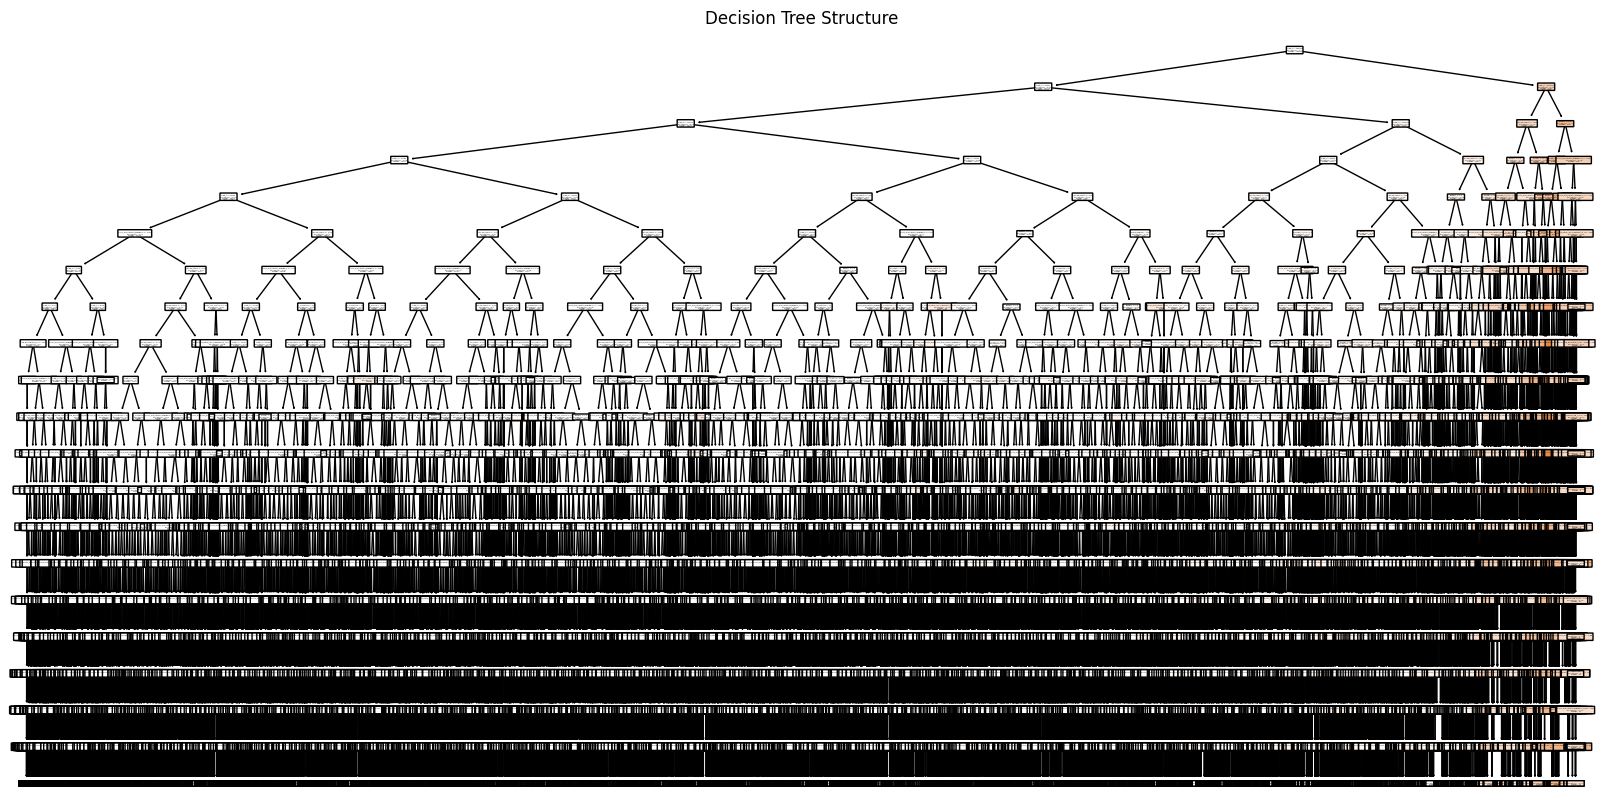

In [15]:
plt.figure(figsize=(20,10))
plot_tree(dt_model, feature_names=X_train.columns, filled=True, rounded=True)
plt.title("Decision Tree Structure")
plt.show()

### Use LIME, SHAP to explained

In [16]:
plt.style.use('style.mplstyle')
shap.initjs()

: 

In [17]:
explainer_dt = shap.Explainer(dt_model, X_train)
shap_values_dt = explainer_dt(X_valid, check_additivity=False)


shap.summary_plot(shap_values_dt, X_valid, plot_type="bar", title="SHAP Decision Tree Feature Importance")


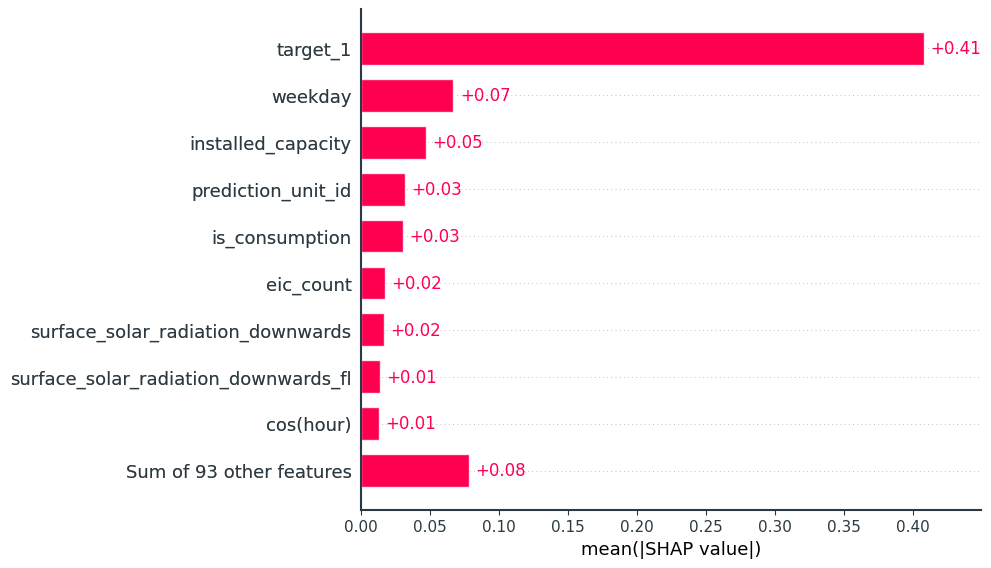

In [ ]:
shap.plots.bar(shap_values_dt, show=False)
plt.show()
# plt.savefig("plots/bar.png")

In [ ]:
i_med = np.argsort(dt_valid_predictions)[len(dt_valid_predictions)//2]
i_max = np.argmax(dt_valid_predictions)
i_80 = np.argsort(dt_valid_predictions)[int(len(dt_valid_predictions)*0.8)]
i_60 = np.argsort(dt_valid_predictions)[int(len(dt_valid_predictions)*0.6)]
i_40 = np.argsort(dt_valid_predictions)[int(len(dt_valid_predictions)*0.4)]
i_20 = np.argsort(dt_valid_predictions)[int(len(dt_valid_predictions)*0.2)]
i_min = np.argmin(dt_valid_predictions)

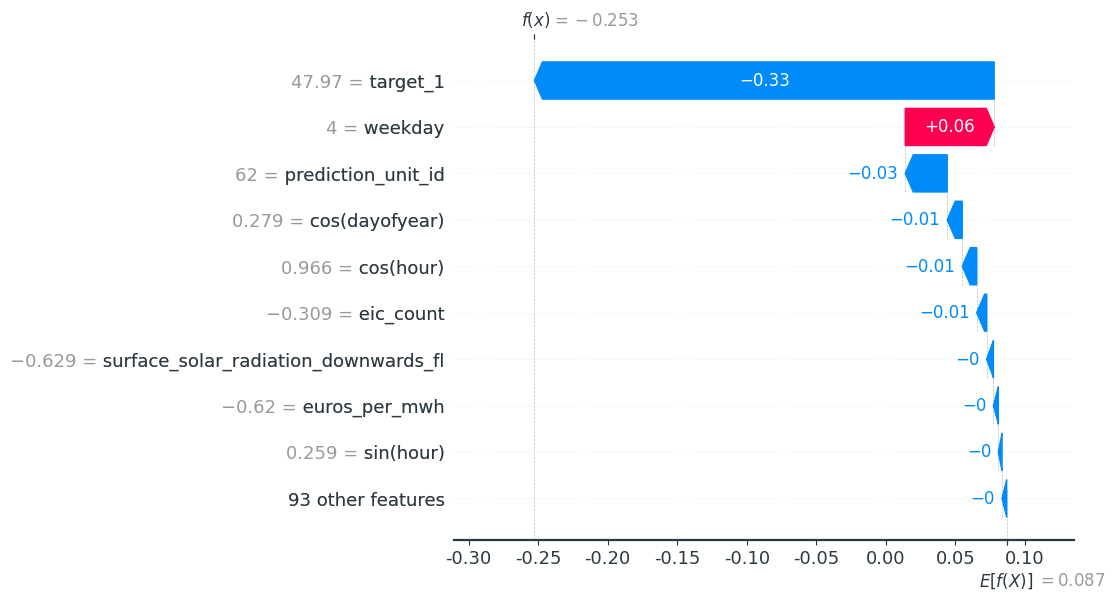

In [ ]:
shap.plots.waterfall(shap_values_dt[i_med],show=True)
plt.show()
# plt.savefig("plots/waterfall_median.png")

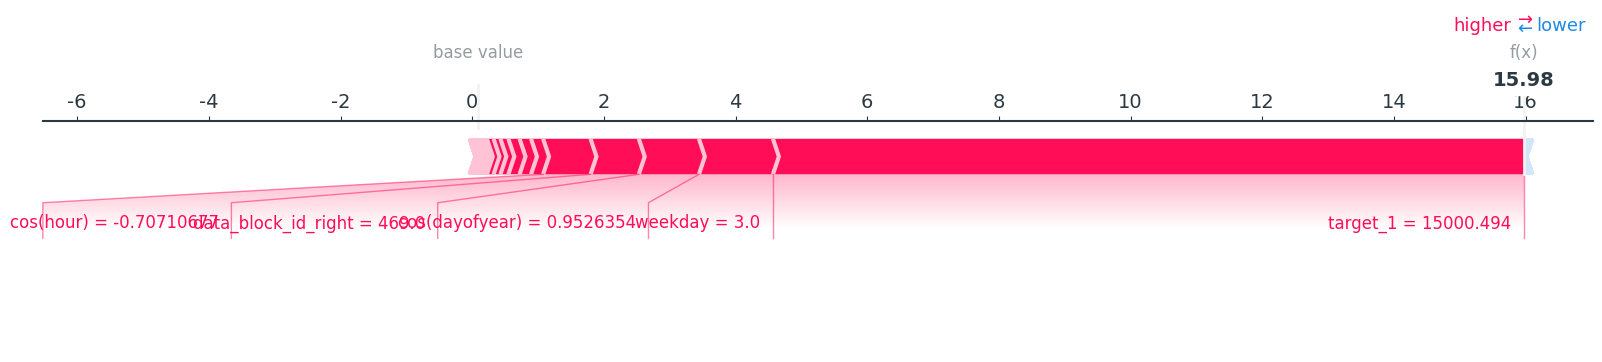

In [ ]:
shap.plots.force(shap_values_dt[i_max], show=False, matplotlib=True)
plt.show()
# plt.savefig("plots/force_max.png")

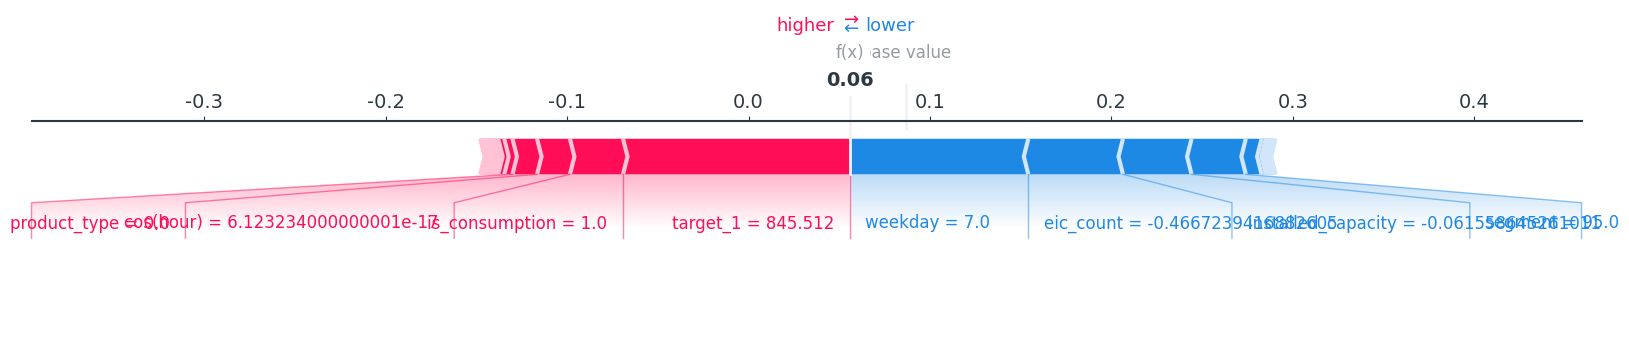

In [ ]:
shap.plots.force(shap_values_dt[i_80], show=False, matplotlib=True)
plt.show()
# plt.savefig("plots/force_80.png")

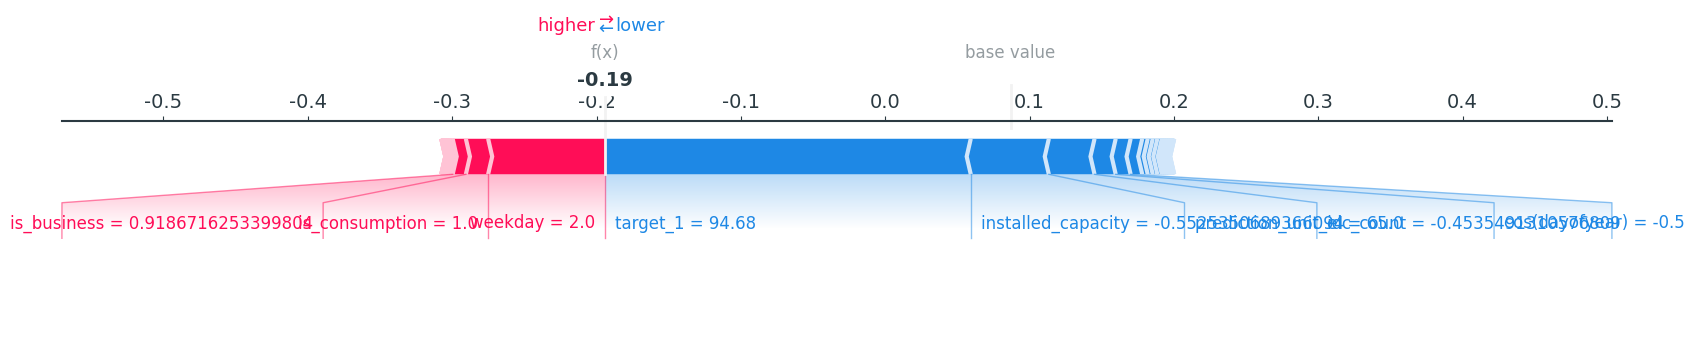

In [ ]:
shap.plots.force(shap_values_dt[i_60], show=False, matplotlib=True)
plt.show()
# plt.savefig("plots/force_60.png")

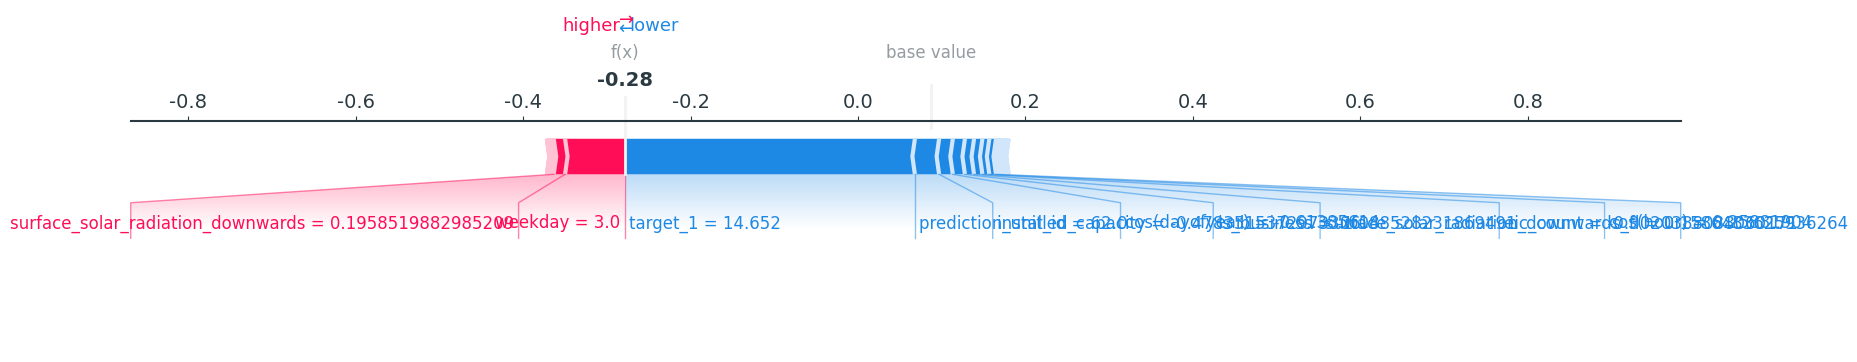

In [ ]:
shap.plots.force(shap_values_dt[i_40], show=False, matplotlib=True)
plt.show()
# plt.savefig("plots/force_40.png")

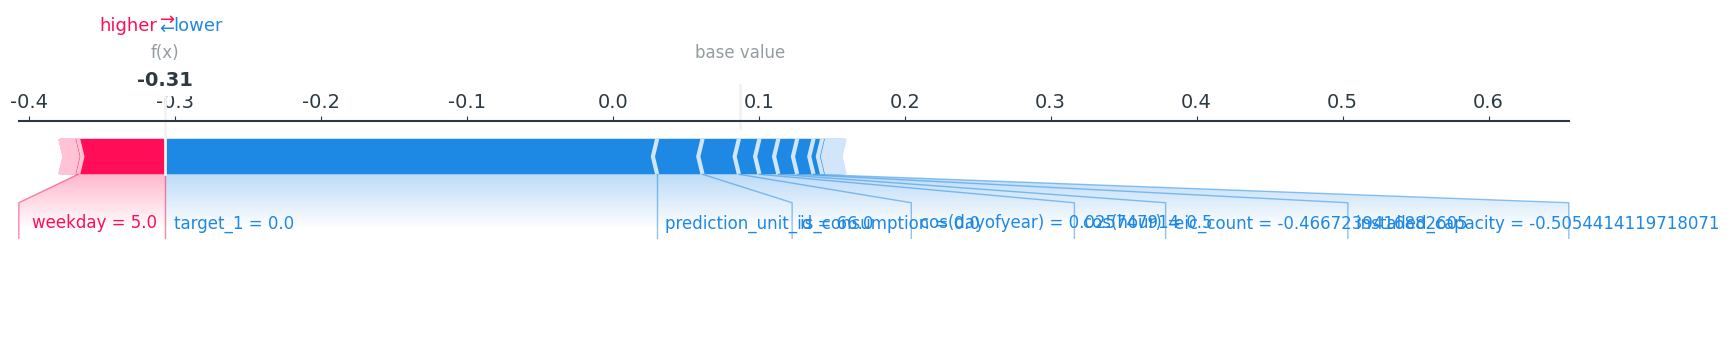

In [ ]:
shap.plots.force(shap_values_dt[i_20], show=False, matplotlib=True)
plt.show()
# plt.savefig("plots/force_20.png")

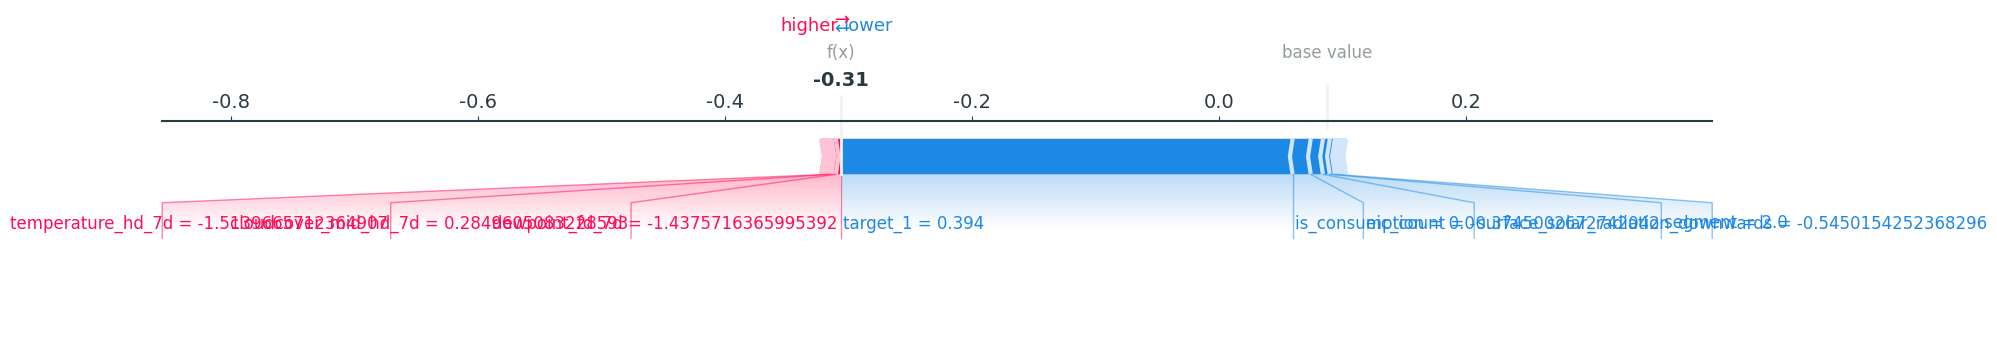

In [ ]:
shap.plots.force(shap_values_dt[i_min], show=False, matplotlib=True)
plt.show()
# plt.savefig("plots/force_min.png")

In [ ]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, mode="regression", feature_names=X_train.columns)
lime_exp_dt = explainer.explain_instance(X_valid.iloc[0].values, dt_model.predict)
file_name = f"{save_dir}/lime_explanation_dt.html"

lime_exp_dt.save_to_file(file_name)
lime_exp_dt.show_in_notebook()


### Build LGBM and Improve in valid set

In [ ]:
lgbm_model=joblib.load(f'{save_dir}/lgbm_model_tuning.joblib')


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.071000 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 21971
[LightGBM] [Info] Number of data points in the train set: 1086844, number of used features: 101
[LightGBM] [Info] Start training from score -0.024564


['../../exps/exp/lgbm_model_tuning.joblib']

In [ ]:
lgbm_model_predictions = lgbm_model.predict(X_valid)
lgbm_model_mae = mean_absolute_error(y_valid, lgbm_model_predictions)
lgbm_model_r2 = r2_score(y_valid, lgbm_model_predictions)
print(f"LGBM model - Validation MAE: {lgbm_model_mae:.3f}, Validation R2: {lgbm_model_r2:.3f}")

LGBM model - Validation MAE: 0.076, Validation R2: 0.949


### Use LIME, SHAP to explained

100%|===================| 535240/535312 [19:34<00:00]        

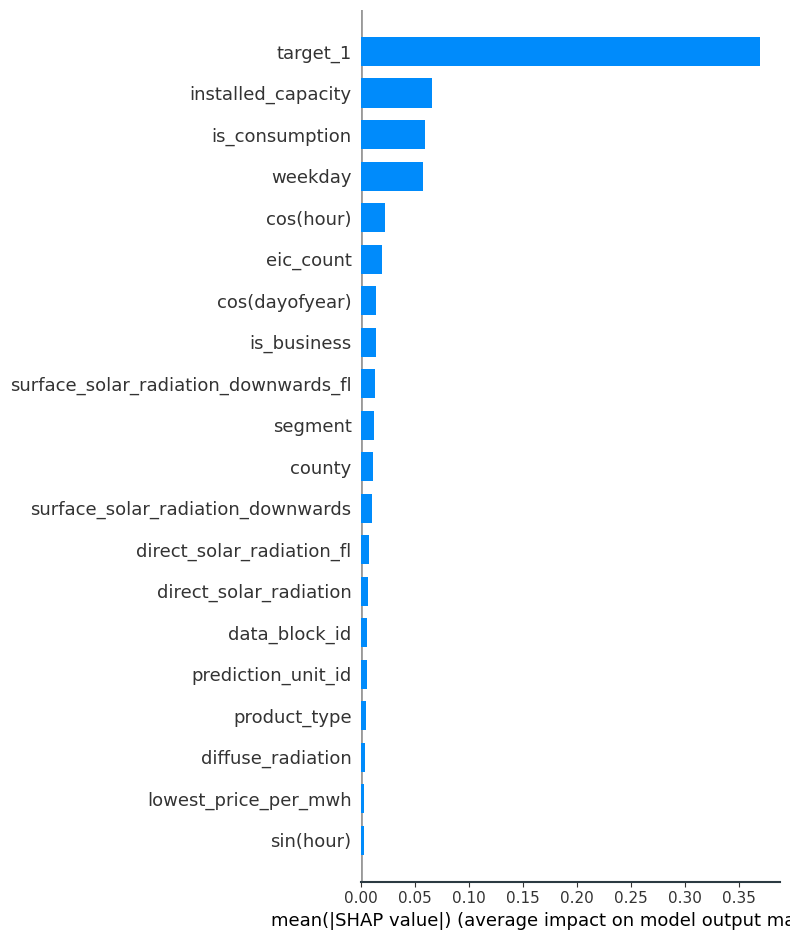

In [ ]:
explainer_lgbm = shap.Explainer(lgbm_model, X_train)
shap_values_lgbm = explainer_lgbm(X_valid, check_additivity=False)


shap.summary_plot(shap_values_lgbm, X_valid, plot_type="bar", title="SHAP LGBM Feature Importance")



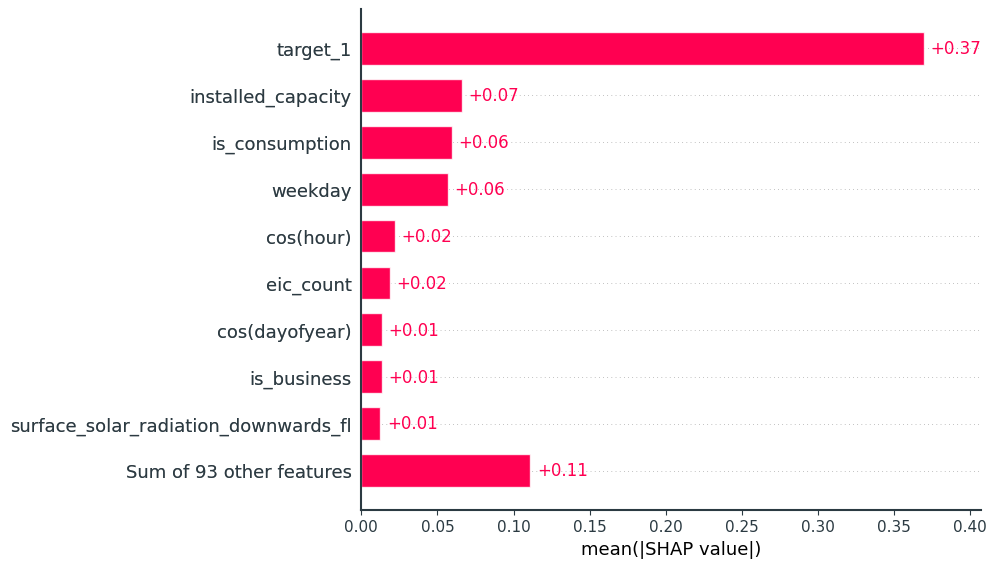

In [ ]:
shap.plots.bar(shap_values_lgbm, show=False)
plt.show()
# plt.savefig("plots/bar.png")

In [ ]:
i_med = np.argsort(lgbm_model_predictions)[len(lgbm_model_predictions)//2]
i_max = np.argmax(lgbm_model_predictions)
i_80 = np.argsort(lgbm_model_predictions)[int(len(lgbm_model_predictions)*0.8)]
i_60 = np.argsort(lgbm_model_predictions)[int(len(lgbm_model_predictions)*0.6)]
i_40 = np.argsort(lgbm_model_predictions)[int(len(lgbm_model_predictions)*0.4)]
i_20 = np.argsort(lgbm_model_predictions)[int(len(lgbm_model_predictions)*0.2)]
i_min = np.argmin(lgbm_model_predictions)

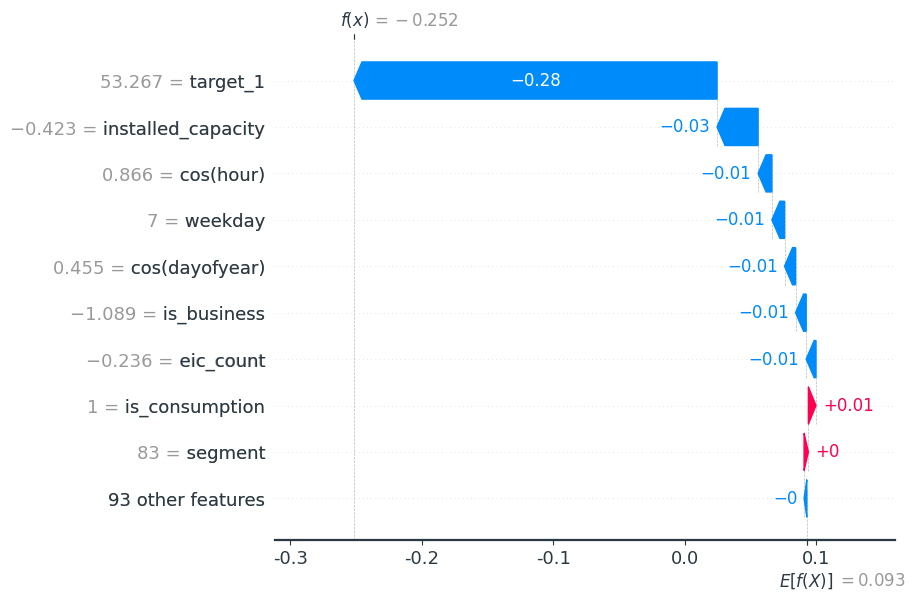

In [ ]:
shap.plots.waterfall(shap_values_lgbm[i_med],show=True)
plt.show()

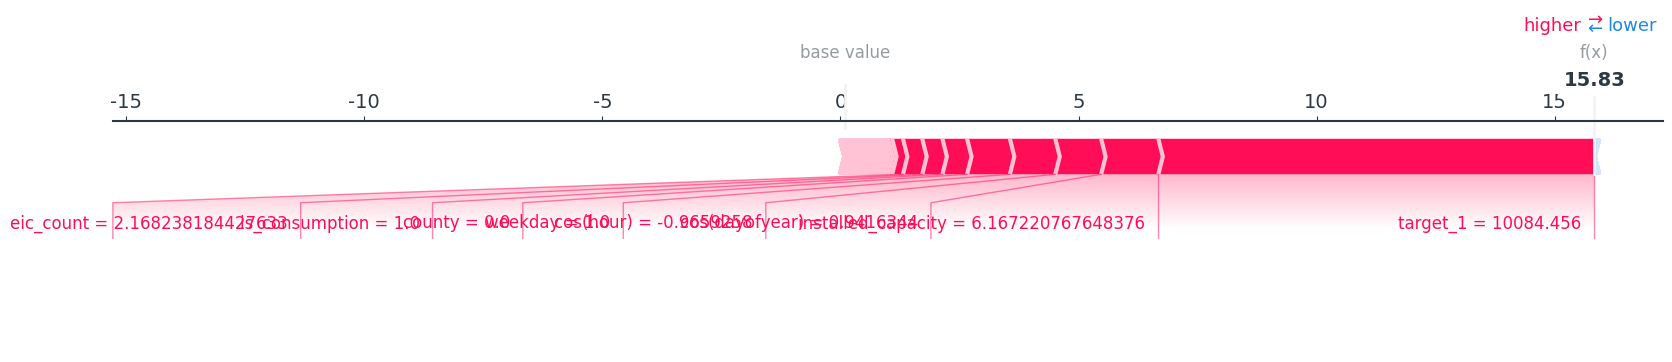

In [ ]:
shap.plots.force(shap_values_lgbm[i_max], show=False, matplotlib=True)
plt.show()

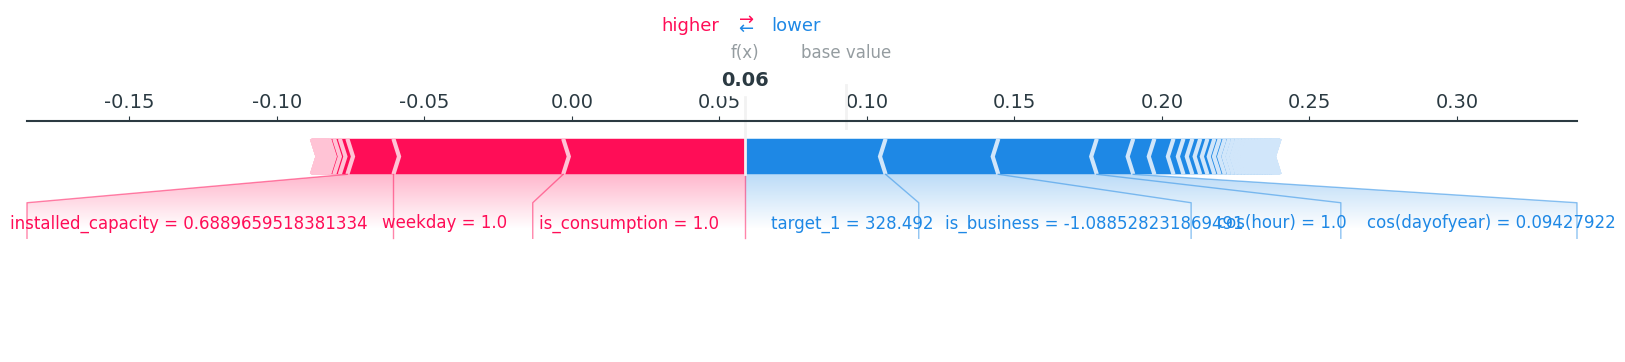

In [ ]:
shap.plots.force(shap_values_lgbm[i_80], show=False, matplotlib=True)
plt.show()

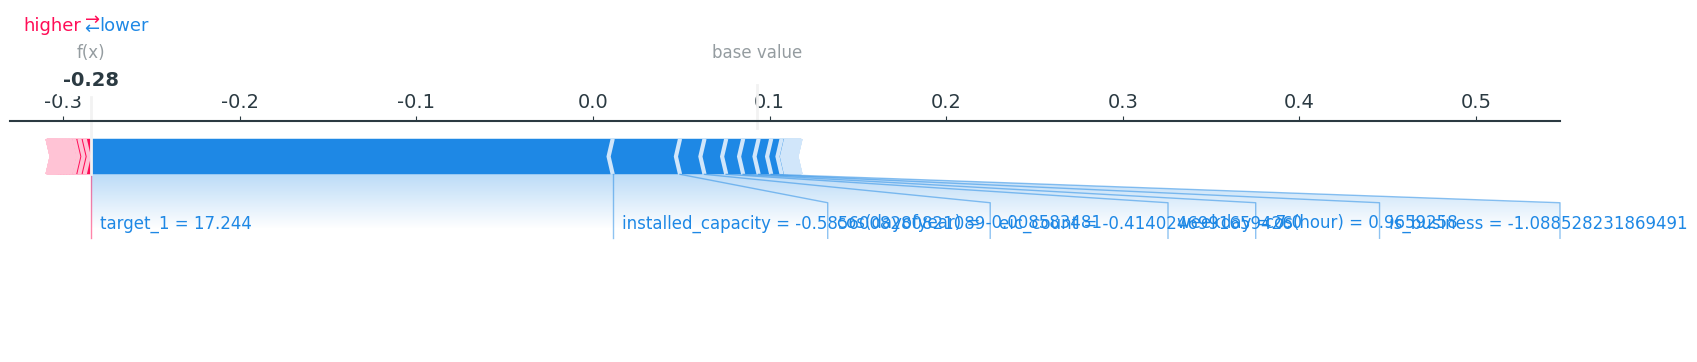

In [ ]:
shap.plots.force(shap_values_lgbm[i_40], show=False, matplotlib=True)
plt.show()

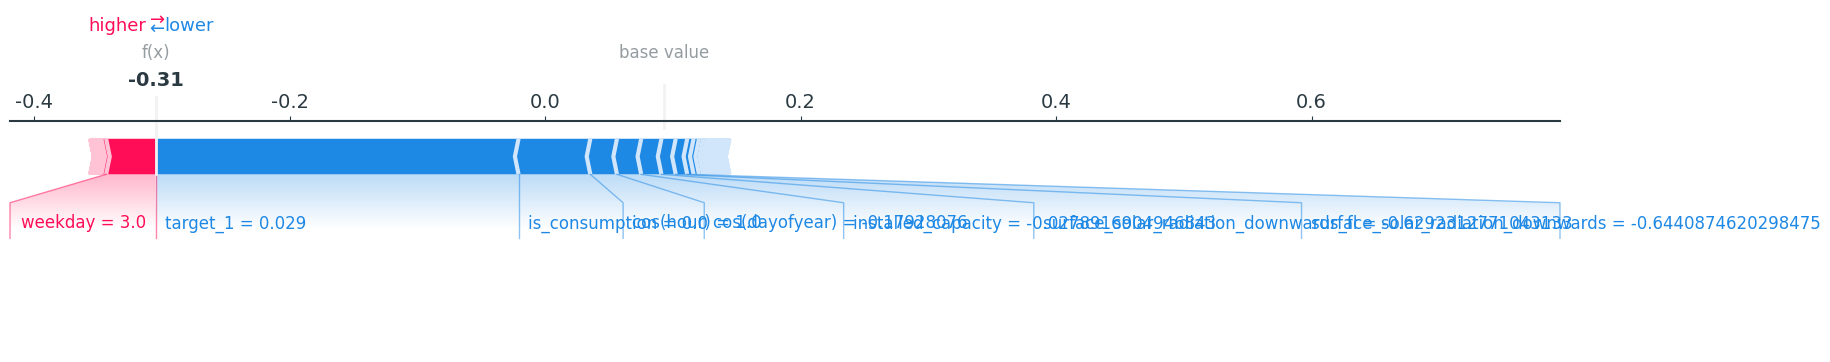

In [ ]:
shap.plots.force(shap_values_lgbm[i_20], show=False, matplotlib=True)
plt.show()

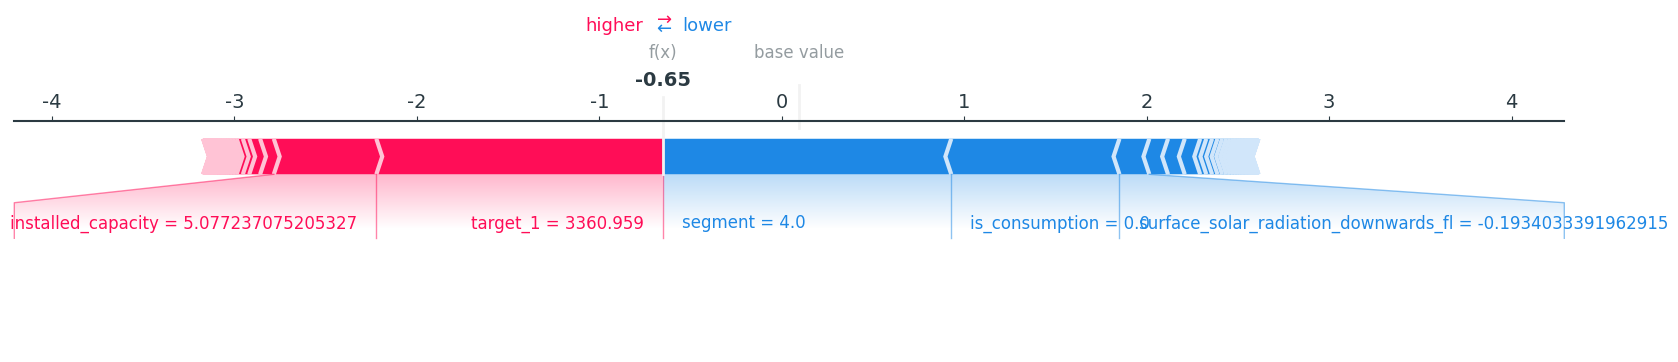

In [ ]:
shap.plots.force(shap_values_lgbm[i_min], show=False, matplotlib=True)
plt.show()

In [ ]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, mode="regression", feature_names=X_train.columns)
lime_exp_lgbm = explainer.explain_instance(X_valid.iloc[0].values, lgbm_model.predict)
file_name = f"{save_dir}/lime_explanation_lgbm.html"

lime_exp_lgbm.save_to_file(file_name)
lime_exp_lgbm.show_in_notebook()
